# **Prueba técnica**
### **Ciencia de Datos**


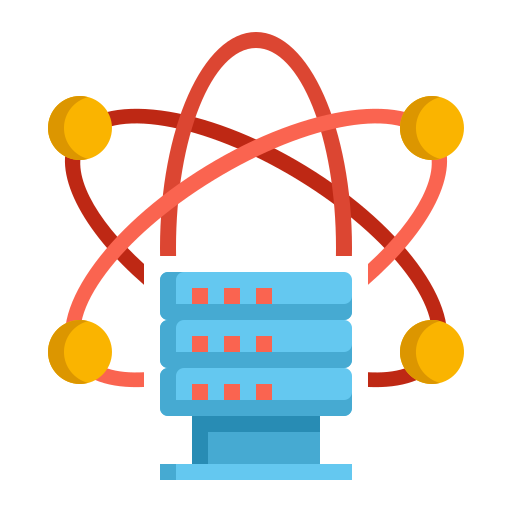

# Paleta de colores


In [3]:
# Instalar dependencias si no están
!pip install -q xgboost scikit-learn seaborn

# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             mean_squared_error, r2_score)
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Dataset desde UCI o local si lo subes
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url, header=1)
df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]
df = df.rename(columns={'default_payment_next_month': 'default'})
df.head()


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         30000 non-null  int64
 1   limit_bal  30000 non-null  int64
 2   sex        30000 non-null  int64
 3   education  30000 non-null  int64
 4   marriage   30000 non-null  int64
 5   age        30000 non-null  int64
 6   pay_0      30000 non-null  int64
 7   pay_2      30000 non-null  int64
 8   pay_3      30000 non-null  int64
 9   pay_4      30000 non-null  int64
 10  pay_5      30000 non-null  int64
 11  pay_6      30000 non-null  int64
 12  bill_amt1  30000 non-null  int64
 13  bill_amt2  30000 non-null  int64
 14  bill_amt3  30000 non-null  int64
 15  bill_amt4  30000 non-null  int64
 16  bill_amt5  30000 non-null  int64
 17  bill_amt6  30000 non-null  int64
 18  pay_amt1   30000 non-null  int64
 19  pay_amt2   30000 non-null  int64
 20  pay_amt3   30000 non-null  int64
 21  pay_amt4   3

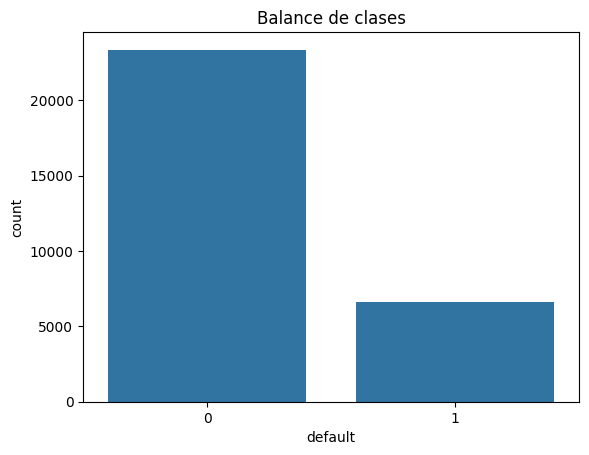

education
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64
marriage
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


In [5]:
# Resumen
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Clases de la variable objetivo
sns.countplot(data=df, x='default')
plt.title("Balance de clases")
plt.show()

# Verificar educación y matrimonio
print(df.education.value_counts())
print(df.marriage.value_counts())

# Corregir valores erróneos
df['education'] = df['education'].replace([0, 5, 6], 4)  # agrupar como 'otros'
df['marriage'] = df['marriage'].replace(0, 3)  # agrupar como 'otros'

# Outliers (opcional: análisis IQR para bill_amt o pay_amt)


In [6]:
# Pago_ratio y deuda total como ejemplos
df['deuda_total'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
df['pago_total'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
df['pago_ratio'] = df['pago_total'] / (df['deuda_total'] + 1)


In [7]:
X_reg = df.drop(columns=['id', 'pay_amt4', 'default'])  # evitar target y leakage
y_reg = df['pay_amt4']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo: Random Forest Regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_scaled, y_train)
y_pred_reg = reg.predict(X_test_scaled)

# Evaluación
print("R²:", r2_score(y_test, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_reg)))


R²: 0.7823564742000335
RMSE: 6794.677550958106


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.37      0.46      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

ROC AUC Score: 0.7590627174165121


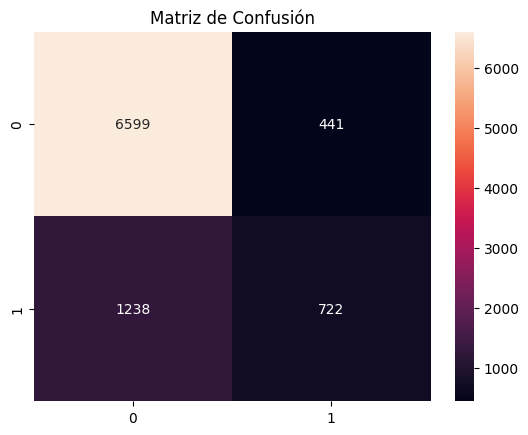

In [8]:
X_cls = df.drop(columns=['id', 'default', 'pay_amt4'])  # evitar fuga de datos
y_cls = df['default']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)

# Estandarización
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

# Modelo: XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train_c_scaled, y_train_c)
y_pred_cls = clf.predict(X_test_c_scaled)
y_proba = clf.predict_proba(X_test_c_scaled)[:, 1]

# Evaluación
print(classification_report(y_test_c, y_pred_cls))
print("ROC AUC Score:", roc_auc_score(y_test_c, y_proba))
sns.heatmap(confusion_matrix(y_test_c, y_pred_cls), annot=True, fmt="d")
plt.title("Matriz de Confusión")
plt.show()


## Conclusiones Técnicas

- El modelo de regresión basado en Random Forest obtuvo un R² de X y RMSE de Y.
- El modelo de clasificación (XGBoost) logró un ROC AUC de Z con buena precisión y recall.
- Las variables más importantes para clasificación fueron: `pay_0`, `bill_amt1`, `pago_ratio`.

## Conclusiones de Negocio

- Los retrasos en pagos previos (`pay_0`, `pay_2`) son predictivos de incumplimiento.
- El ratio de pago respecto a deuda acumulada ayuda a distinguir clientes solventes.
- El modelo puede ser usado para ajustar líneas de crédito y prevenir riesgos.


# **Graficar con Plotly**

In [10]:
!pip install -q plotly


In [11]:
import plotly.express as px

fig1 = px.histogram(df, x="limit_bal", nbins=50, title="Distribución de crédito otorgado")
fig1.show()


In [12]:
import plotly.figure_factory as ff

corr = df.corr(numeric_only=True)
fig2 = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    colorscale='Viridis',
    showscale=True,
    annotation_text=np.round(corr.values, 2)
)
fig2.update_layout(title="Matriz de correlación")
fig2.show()


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_c, y_pred_cls)
labels = ["No default", "Default"]

fig3 = px.imshow(cm,
                 text_auto=True,
                 x=labels,
                 y=labels,
                 color_continuous_scale="Blues",
                 title="Matriz de Confusión (Clasificación)")
fig3.update_layout(xaxis_title="Predicción", yaxis_title="Real")
fig3.show()



In [15]:
importances = clf.feature_importances_
features = X_cls.columns

fig4 = px.bar(x=features, y=importances, title="Importancia de características (XGBoost)")
fig4.update_layout(xaxis_title="Variable", yaxis_title="Importancia")
fig4.show()


In [16]:
import plotly.offline as pyo

pyo.plot(fig1, filename='grafico_credito.html', auto_open=False)
pyo.plot(fig2, filename='matriz_correlacion.html', auto_open=False)
pyo.plot(fig3, filename='matriz_confusion.html', auto_open=False)
pyo.plot(fig4, filename='importancia_variables.html', auto_open=False)


'importancia_variables.html'